## This code takes the college basketball data and models it using logistic regression

In [209]:
#import packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval, anneal
import hyperopt.pyll.stochastic
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [210]:
#creating functions to evaluate model fit

def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


def evaluate_classification(model, test_features, test_labels, extra = False):
    
    predictions = model.predict(test_features)
    
    accuracy = sum(predictions == test_labels)/len(test_labels)
    
    class_rep = classification_report(test_labels, predictions, digits = 4)
    
    cf_matrix = confusion_matrix(test_labels, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = ['Predicted Loss', 'Predicted Win'],
               yticklabels = ['Actual Loss', 'Actual Win'])
    

    print('Model Performance\n')
    print('Accuracy = ',(accuracy),'\n')
    print('Classification Report\n')
    print(class_rep)
    plt.show()
    
    
    
    if extra == True:
        
        probas = model.predict_proba(test_features)[:, 1]
        
        print('Area Under the Curve =', roc_auc_score(test_labels, probas))
        
        
        
        roc_values = []
        for thresh in np.linspace(0, 1, 100):
            preds = get_preds(thresh, probas)
            tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            roc_values.append([tpr, fpr])
            
        tpr_values, fpr_values = zip(*roc_values)
        
        fig, ax = plt.subplots(figsize=(10,7))
        ax.plot(fpr_values, tpr_values)
        ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
        plt.title('Receiver Operating Characteristic Curve', fontsize=18)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)
        plt.legend(fontsize=12)
        
        plt.show()
        
def compare_classification(model1, model2, test_features1, test_features2, test_labels):
    
    predictions1 = model1.predict(test_features1)
    predictions2 = model2.predict(test_features2)
    
    probas1 = model1.predict_proba(test_features1)[:, 1]
    probas2 = model2.predict_proba(test_features2)[:, 1]
    
    auc1 = roc_auc_score(test_labels, probas1)
    auc2 = roc_auc_score(test_labels, probas2)
    
    accuracy1 = sum(predictions1 == test_labels)/len(test_labels)
    accuracy2 = sum(predictions2 == test_labels)/len(test_labels)
    
    class_rep1 = classification_report(test_labels, predictions1, digits = 4)
    class_rep2 = classification_report(test_labels, predictions2, digits = 4)
    
    acc_diff = accuracy2 - accuracy1
    auc_diff = auc2 - auc1
    
    
    if acc_diff > 0:
        result_acc = 'Accuracy: Model 2 better'
    elif acc_diff == 0:
        result_acc = "Accuracy: Models perform the same"
    else:
        result_acc = "Accuracy: Model 1 better"
        
    if auc_diff > 0:
        result_auc = 'AUC: Model 2 better'
    elif auc_diff == 0:
        result_auc = "AUC: Models perform the same"
    else:
        result_auc = "AUC: Model 1 better"
    
    print('           Model 1 Performance   ', 'Model 2 Performance', '  Difference (Model2 - Model1)')
    print('Accuracy: ',(accuracy1),"   ",(accuracy2),"   ",(acc_diff),"    ",result_acc)
    print('AUC: ',(auc1),"   ",(auc2),"   ",(auc_diff),"    ",result_auc)

## Importing data and conducting minor cleaning including converting the outcome varible to 0/1, then setting up training and testing sets

In [211]:
#import data
full_data = pd.read_csv("College Data/Weighted Mean Converted Data.csv")

In [212]:
#inspect data columns
full_data.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'Location', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA',
       'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1',
       'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1',
       'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1',
       'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1',
       'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1'],
      dtype='object')

In [213]:
full_data.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,Location,FG,FGA,...,ORB%.1,FT/FGA.1,DRB%.1,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,A,23.000000,57.000000,...,0.264706,0.174603,0.813953,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,N,31.000000,60.833333,...,0.291657,0.214480,0.806891,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,N,28.600000,59.700000,...,0.139543,0.301987,0.795111,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,N,27.733333,57.466667,...,0.249515,0.118953,0.856104,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,A,26.095238,58.190476,...,0.281522,0.178352,0.713698,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669


In [214]:
#converting Location variable with one-hot encoding (dummy coding)

full_data_adv = pd.get_dummies(full_data, columns = ['Location'])

full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0


In [215]:
full_data_adv.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%',
       'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1',
       'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1',
       'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1', 'TOV%.1',
       'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1',
       'POSS.1', 'OffRt.1', 'DefRt.1', 'Location_A', 'Location_H',
       'Location_N'],
      dtype='object')

In [216]:
#creating overtime variable

full_data_adv['OT'] = full_data_adv['W/L'].str.split().str[2].str[0:2]
full_data_adv['OT'].fillna(0, inplace = True)
full_data_adv['OT'].replace('OT', 1, inplace = True)

In [217]:
#examining outcome variable values
full_data_adv['W/L'].unique()

array(['L', 'W', 'L\xa0(2 OT)', 'L\xa0(1 OT)', 'W\xa0(1 OT)',
       'W\xa0(4 OT)', 'W\xa0(2 OT)', 'W\xa0(3 OT)', 'L\xa0(3 OT)',
       'L\xa0(4 OT)'], dtype=object)

In [218]:
#removing extra text in win loss variable
full_data_adv['W/L'] = full_data_adv['W/L'].str.split().str[0]
full_data_adv['W/L'].unique()

array(['L', 'W'], dtype=object)

In [219]:
#Converting outcome variable from string to numeric
full_data_adv.replace({"W/L": {"W":1, "L":0}}, inplace = True)

In [220]:
#looking at cleaned data
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [221]:
#examining number of rows and columns of cleaned data
full_data_adv.shape

(10693, 67)

In [222]:
#examining all variable types
pd.options.display.max_rows = 70
print(full_data_adv.dtypes)
pd.options.display.max_rows = 10

Date           object
G               int64
Opp            object
W/L             int64
Opp.1           int64
Tm              int64
Team           object
FG            float64
FGA           float64
FG%           float64
3P            float64
3PA           float64
3P%           float64
FT            float64
FTA           float64
FT%           float64
ORB           float64
TRB           float64
AST           float64
STL           float64
BLK           float64
TOV           float64
PF            float64
eFG           float64
TOV%          float64
ORB%          float64
FT/FGA        float64
DRB%          float64
AST%          float64
TS%           float64
3PAr          float64
DRB           float64
POSS          float64
OffRt         float64
DefRt         float64
FG.1          float64
FGA.1         float64
FG%.1         float64
3P.1          float64
3PA.1         float64
3P%.1         float64
FT.1          float64
FTA.1         float64
FT%.1         float64
ORB.1         float64
TRB.1     

In [223]:
#droping any duplicate rows
full_data_adv.dropna().drop_duplicates()
full_data_adv.shape

(10693, 67)

In [224]:
#columns that will not be used as features



fields_to_drop = ['G', 'Date', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'OT']

#fields_to_keep = []



In [225]:
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [226]:
#creating feature data and examining number of rows and columns

X = full_data_adv.drop(columns = fields_to_drop)

print(X.shape)
X.columns

(10693, 59)


Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%',
       'FT/FGA', 'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt',
       'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1',
       'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1',
       'PF.1', 'eFG.1', 'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1',
       'TS%.1', '3PAr.1', 'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H', 'Location_N'],
      dtype='object')

In [227]:
#Create outcome data

y = full_data_adv['W/L'].values


y.shape

(10693,)

In [228]:
#Create training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

In [229]:
#Standardizing the predictor variables into Z scores

#take categorical variables and one-hot encode
dummy_train = X_train[['Location_A','Location_H','Location_N']]
dummy_train.reset_index(drop = True, inplace = True)
dummy_test = X_test[['Location_A','Location_H','Location_N']]
dummy_test.reset_index(drop = True, inplace = True)

#create subset of data with just continuous variables
X_train1 = X_train.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_test1 =  X_test.drop(['Location_A','Location_H','Location_N'], axis = 1)

#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#combine continuous and categorical variables
X_train_d = pd.concat([X_train_std, dummy_train], axis = 1)
X_test_d = pd.concat([X_test_std, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full = X_train_d.drop(['Location_N'], axis = 1)
X_test_full = X_test_d.drop(['Location_N'], axis = 1)

## Running a basic logistic regression model and examining the results

In [230]:
#create basic logistic regression object
logreg = LogisticRegression(random_state = 42, max_iter = 1000)

In [231]:
#fit basic logistic regression model to training data
logreg.fit(X_train_full,y_train)

LogisticRegression(max_iter=1000, random_state=42)

Model Performance

Accuracy =  0.6783844427823486 

Classification Report

              precision    recall  f1-score   support

           0     0.6862    0.6679    0.6769      1349
           1     0.6708    0.6891    0.6798      1325

    accuracy                         0.6784      2674
   macro avg     0.6785    0.6785    0.6784      2674
weighted avg     0.6786    0.6784    0.6784      2674



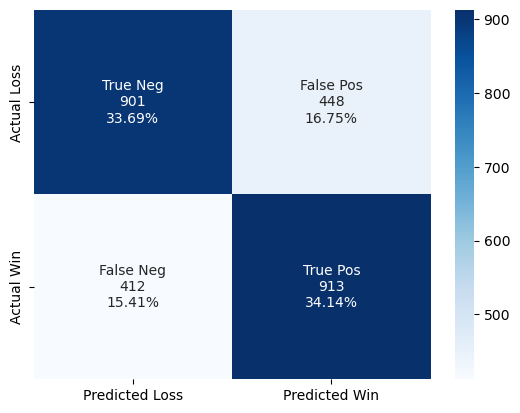

Area Under the Curve = 0.7386592444438228


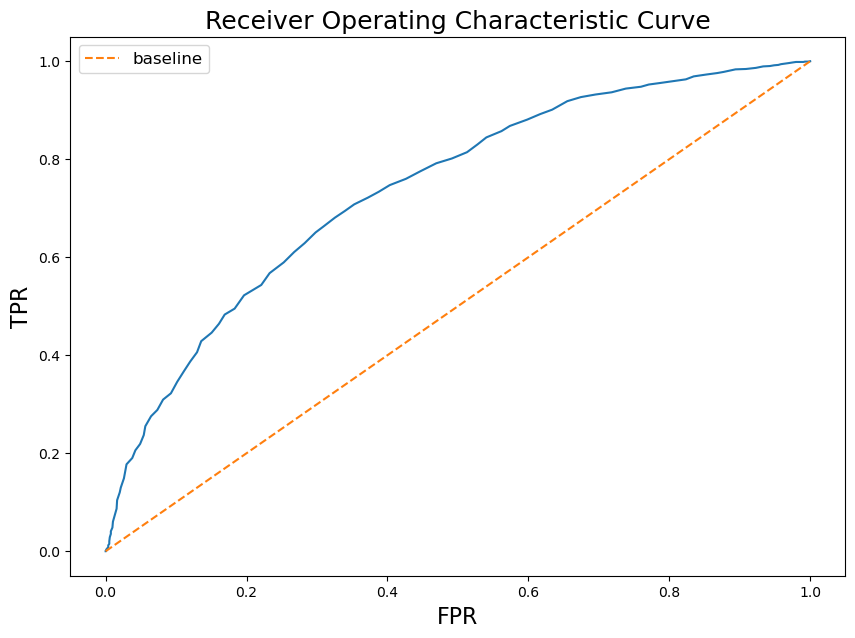

In [232]:
#evaluate trained logistic regression model on test data

evaluate_classification(logreg, X_test_full, y_test, extra = True)

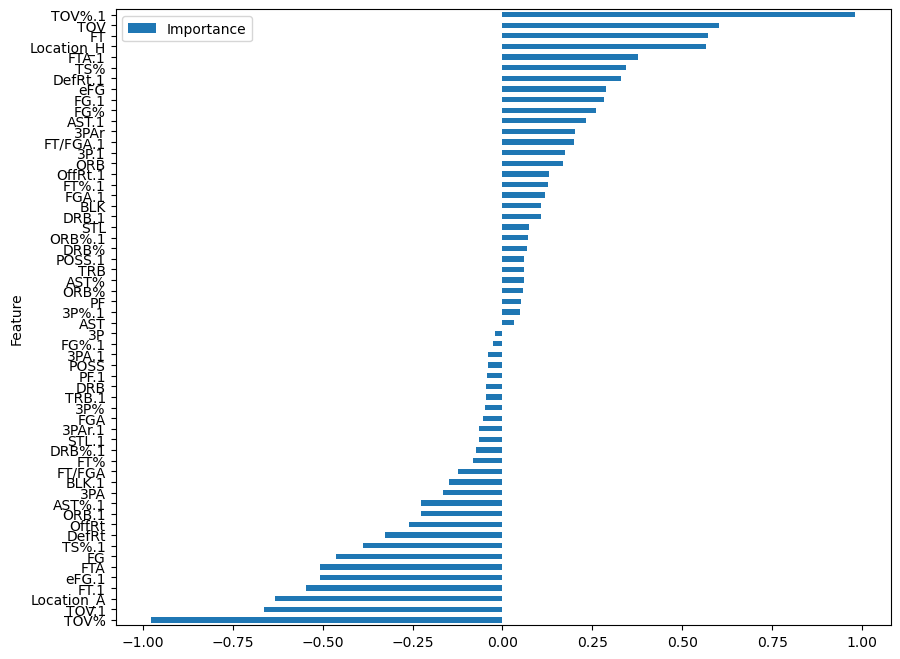

In [233]:
#examining variable importance
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [234]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
17        TOV%   -0.978235
42       TOV.1   -0.663499
56  Location_A   -0.633756
34        FT.1   -0.545128
44       eFG.1   -0.508619
7          FTA   -0.507788
0           FG   -0.461907
50       TS%.1   -0.387448
27       DefRt   -0.325657
26       OffRt   -0.259374
37       ORB.1   -0.226282
49      AST%.1   -0.225341
4          3PA   -0.164383
41       BLK.1   -0.147963
19      FT/FGA   -0.124808
8          FT%   -0.081576
48      DRB%.1   -0.073802
40       STL.1   -0.066192
51      3PAr.1   -0.064591
1          FGA   -0.053595
5          3P%   -0.048990
38       TRB.1   -0.046663
24         DRB   -0.044619
43        PF.1   -0.043326
25        POSS   -0.041289
32       3PA.1   -0.039750
30       FG%.1   -0.027295
3           3P   -0.020488
11         AST    0.032722
33       3P%.1    0.048923
15          PF    0.051739
18        ORB%    0.057907
21        AST%    0.059856
10         TRB    0.060305
53      POSS.1    0.060922
20        DRB%    0.068404
4

## Note: Many of out variables are not that important, so we can probably remove some of them later, but first lets optimize the model for this full set of variables

## Now lets use hyperopt to optimize the Logistic Regression

In [271]:
#create function to optimize
def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    return cross_val_score(model, X_train_full, y_train).mean()


In [272]:
#assign values for hyperopt to explore as it searches for optimal parameters
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['lbfgs',
                                  'liblinear',
                                  'saga',
                                  'sag']),
    'C': hp.uniform('C', 0.0, 0.1),
    'max_iter': 5000,
    'random_state': 42,
}


In [274]:
#define the function that will run and what to output when new combinations of values produce better results
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}

rstate = np.random.RandomState(42)

#start the search
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials,
           rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                         
0.6725265750159848                                                                
{'C': 0.06201189976766411, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
1                                                                                 
new best:                                                                         
0.6726512632952865                                                                
{'C': 0.06082491621711366, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag'}
2                                                                                 
new best:                                                                         
0.6780133260112352                                                                
{'C': 0.007366102545052411, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
3                                 

In [238]:
#examine best parameters
best1 = space_eval(space, best)
best1

{'C': 0.0045903798895571574,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs'}

In [239]:
#train model using best parameters from search
hyp_logreg = LogisticRegression(C = best1['C'],
                  max_iter = best1['max_iter'],
                  penalty = best1['penalty'],
                  solver = best1['solver'],
                  random_state =  best1['random_state'])

hyp_logreg.fit(X_train_full, y_train)

LogisticRegression(C=0.0045903798895571574, max_iter=5000, random_state=42)

In [240]:
#examine accuracy on training data
y_pred = hyp_logreg.predict(X_train_full)
print('Training Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3980
           1       0.68      0.68      0.68      4039

    accuracy                           0.68      8019
   macro avg       0.68      0.68      0.68      8019
weighted avg       0.68      0.68      0.68      8019



In [241]:
#examine accuracy on test data
y_pred = hyp_logreg.predict(X_test_full)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_test, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.69      0.67      0.68      1349
           1       0.67      0.68      0.68      1325

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.6795063575168288 

Classification Report

              precision    recall  f1-score   support

           0     0.6852    0.6746    0.6799      1349
           1     0.6738    0.6845    0.6791      1325

    accuracy                         0.6795      2674
   macro avg     0.6795    0.6796    0.6795      2674
weighted avg     0.6796    0.6795    0.6795      2674



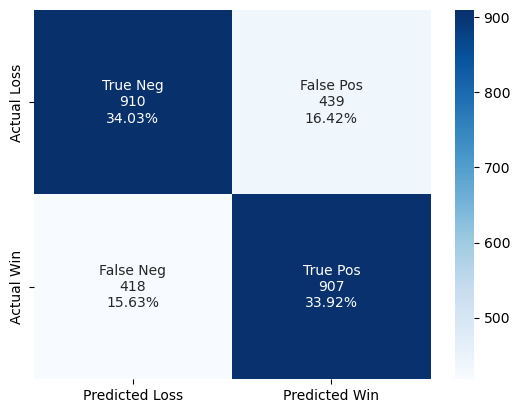

Area Under the Curve = 0.7432815362882359


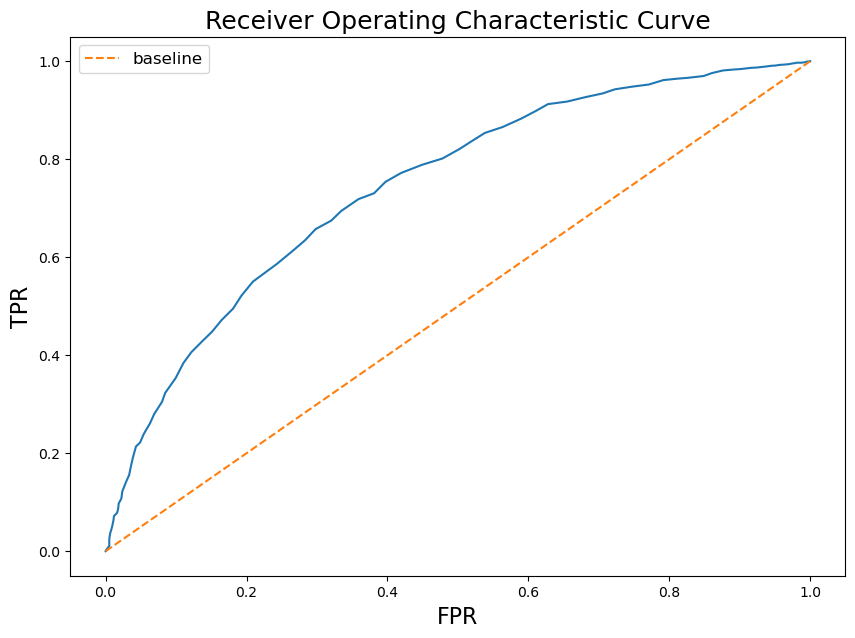

In [242]:
#further investigate accuracy on test data
evaluate_classification(hyp_logreg, X_test_full, y_test, extra = True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

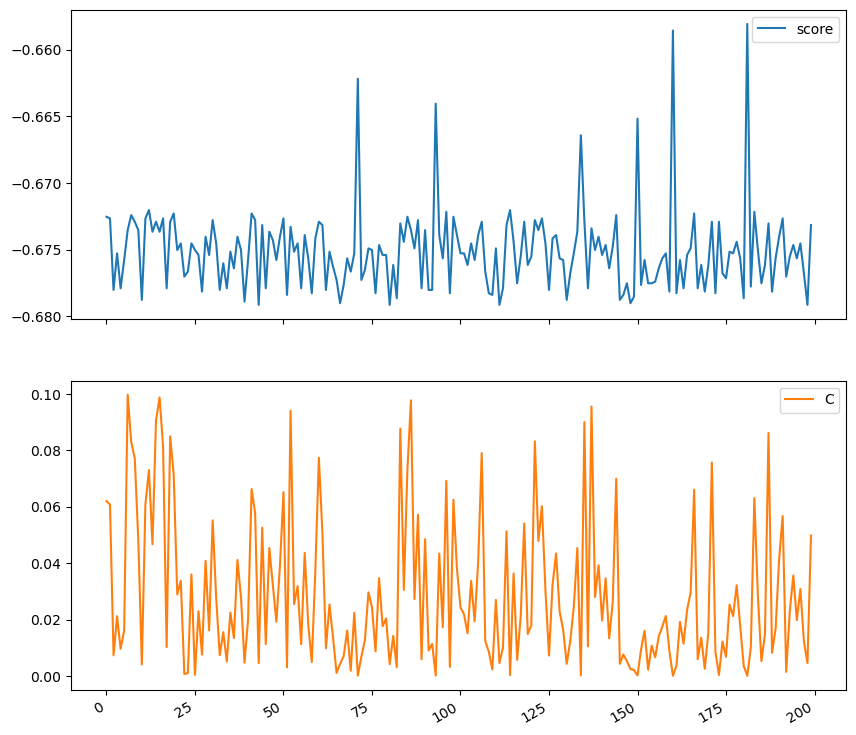

In [243]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

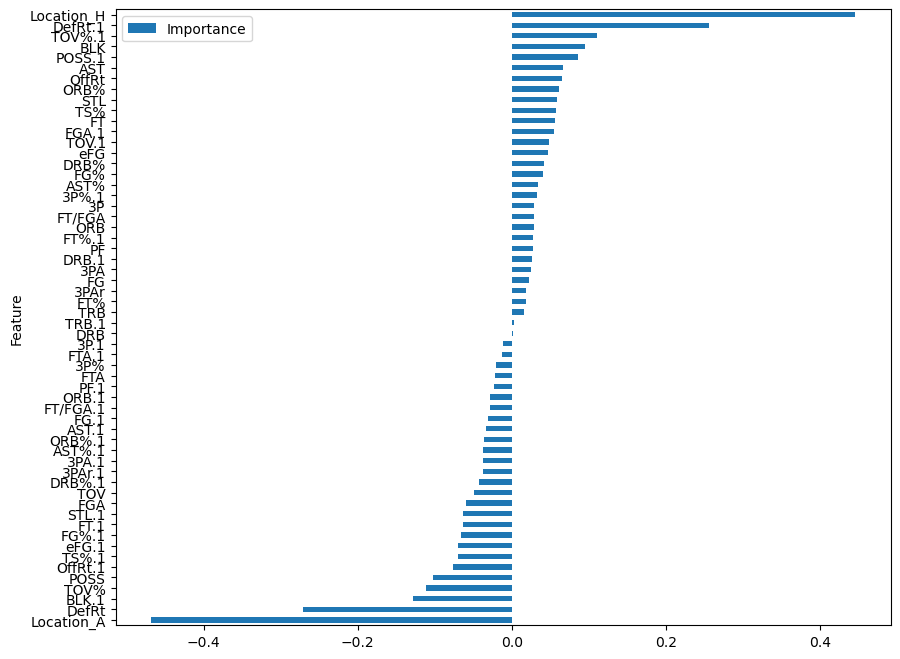

In [244]:
#examining variable importance
coefficients = hyp_logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [245]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
56  Location_A   -0.468672
27       DefRt   -0.271512
41       BLK.1   -0.128644
17        TOV%   -0.111450
25        POSS   -0.102664
54     OffRt.1   -0.076515
50       TS%.1   -0.069814
44       eFG.1   -0.069533
30       FG%.1   -0.066042
34        FT.1   -0.063160
40       STL.1   -0.063106
1          FGA   -0.059469
14         TOV   -0.049685
48      DRB%.1   -0.043065
51      3PAr.1   -0.037773
32       3PA.1   -0.037481
49      AST%.1   -0.037069
46      ORB%.1   -0.036909
39       AST.1   -0.033091
28        FG.1   -0.030656
47    FT/FGA.1   -0.029005
37       ORB.1   -0.028976
43        PF.1   -0.022729
7          FTA   -0.022272
5          3P%   -0.021223
35       FTA.1   -0.012440
31        3P.1   -0.011665
24         DRB    0.001241
38       TRB.1    0.002808
10         TRB    0.016238
8          FT%    0.018023
23        3PAr    0.018040
0           FG    0.022620
4          3PA    0.024888
52       DRB.1    0.025939
15          PF    0.027562
3

In [246]:
#compare original logistic regression to optimized
compare_classification(logreg, hyp_logreg, X_test_full, X_test_full, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6783844427823486     0.6795063575168288     0.0011219147344802005      Accuracy: Model 2 better
AUC:  0.7386592444438228     0.7432815362882359     0.004622291844413096      AUC: Model 2 better


## The optimized model performs better than the base model and we see that the variable importance even more so shows there are only a few important variables

## It may be the case that some variables are not that important, as a result we can try using Recrusive Feature Selection to narrow down our variable list

In [247]:
#creating a base Logistic Regression model object
# then creating a recursive feature elimination object
# then fitting to the training data
LR_estimator = LogisticRegression(random_state=42, max_iter = 5000)
LR_select = RFECV(LR_estimator, step=1, cv=5, n_jobs = -1)
LR_selector = LR_select.fit(X_train_full, y_train)


In [248]:
#examining how many of the original features were retained
(LR_selector.support_).sum()

34

In [249]:
#examining which features were retained
X_train_full.columns[LR_selector.support_]

Index(['FG', 'FG%', '3PA', 'FT', 'FTA', 'ORB', 'TOV', 'TOV%', 'FT/FGA', 'AST%',
       'TS%', '3PAr', 'OffRt', 'DefRt', 'FG.1', '3P.1', 'FT.1', 'FTA.1',
       'FT%.1', 'ORB.1', 'AST.1', 'BLK.1', 'TOV.1', 'eFG.1', 'TOV%.1',
       'FT/FGA.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H'],
      dtype='object')

In [250]:
#examining which features were removed
X_train_full.columns[~LR_selector.support_]

Index(['FGA', '3P', '3P%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'PF', 'eFG',
       'ORB%', 'DRB%', 'DRB', 'POSS', 'FGA.1', 'FG%.1', '3PA.1', '3P%.1',
       'TRB.1', 'STL.1', 'PF.1', 'ORB%.1', 'DRB%.1', 'POSS.1'],
      dtype='object')

In [255]:
#creating training data the contains only the retained features
X_train_full_rfe = X_train_full[X_train_full.columns[LR_selector.support_]]
X_test_full_rfe = X_test_full[X_train_full.columns[LR_selector.support_]]

In [253]:
#creating a base logistic regression object
logreg_rfe = LogisticRegression(random_state = 42, max_iter = 5000)

In [256]:
#fitting the model to the subset of features
logreg_rfe.fit(X_train_full_rfe, y_train)

LogisticRegression(max_iter=5000, random_state=42)

Model Performance

Accuracy =  0.6705310396409873 

Classification Report

              precision    recall  f1-score   support

           0     0.6775    0.6620    0.6697      1349
           1     0.6637    0.6792    0.6714      1325

    accuracy                         0.6705      2674
   macro avg     0.6706    0.6706    0.6705      2674
weighted avg     0.6707    0.6705    0.6705      2674



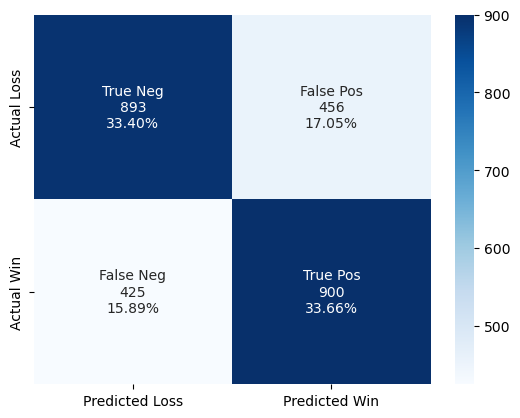

Area Under the Curve = 0.7344313747429962


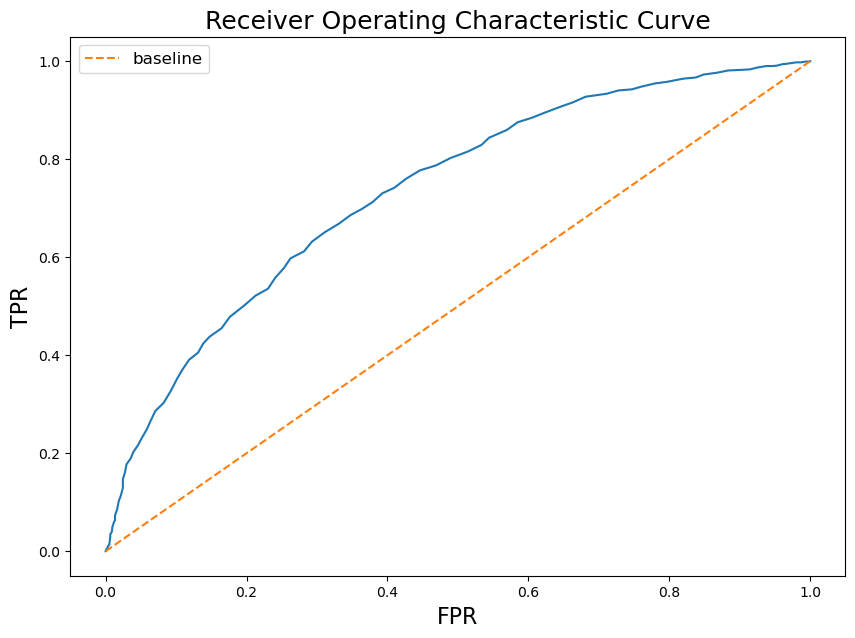

In [258]:
#evaluating reduced features model
evaluate_classification(logreg_rfe, X_test_full_rfe, y_test, extra = True)

In [259]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, logreg_rfe, X_test_full, X_test_full_rfe, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6795063575168288     0.6705310396409873     -0.008975317875841493      Accuracy: Model 1 better
AUC:  0.7432815362882359     0.7344313747429962     -0.008850161545239654      AUC: Model 1 better


## The optimized logistic regression with the full variable set model performs better
## Lets also try optimizing the RFE model

In [260]:
def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    return cross_val_score(model, X_train_full_rfe, y_train).mean()


In [261]:
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['saga',
                                   'liblinear',
                                  'lbfgs',
                                  'sag']),
    'C': hp.uniform('C', 0.0,1.0),
    'max_iter': 5000,
    'random_state': 42,
}


In [263]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                         
0.6735239256817408                                                                
{'C': 0.620118997676641, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
1                                                                                 
new best:                                                                         
0.6740230677205925                                                                
{'C': 0.21221711699333523, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
4                                                                                 
new best:                                                                         
0.6743970547741689                                                                
{'C': 0.16102410861748417, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs'}
6                                   

In [264]:
#examine best parameters
best2 = space_eval(space, best)
best2

{'C': 0.0012241844720292739,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'sag'}

In [265]:
#train model using best parameters
hyp_rfe = LogisticRegression(C = best2['C'],
                  max_iter = best2['max_iter'],
                  penalty = best2['penalty'],
                  solver = best2['solver'],
                  random_state =  best2['random_state'])

hyp_rfe.fit(X_train_full_rfe, y_train)

LogisticRegression(C=0.0012241844720292739, max_iter=5000, random_state=42,
                   solver='sag')

In [266]:
y_pred = hyp_rfe.predict(X_train_full_rfe)
print('Training Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.67      0.67      3980
           1       0.68      0.69      0.68      4039

    accuracy                           0.68      8019
   macro avg       0.68      0.68      0.68      8019
weighted avg       0.68      0.68      0.68      8019



In [267]:
y_pred = hyp_rfe.predict(X_test_full_rfe)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_test, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.66      0.67      1349
           1       0.66      0.68      0.67      1325

    accuracy                           0.67      2674
   macro avg       0.67      0.67      0.67      2674
weighted avg       0.67      0.67      0.67      2674



Model Performance

Accuracy =  0.6709050112191474 

Classification Report

              precision    recall  f1-score   support

           0     0.6786    0.6605    0.6694      1349
           1     0.6635    0.6815    0.6724      1325

    accuracy                         0.6709      2674
   macro avg     0.6710    0.6710    0.6709      2674
weighted avg     0.6711    0.6709    0.6709      2674



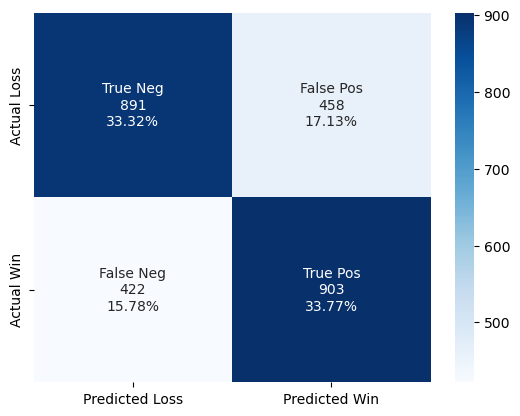

In [275]:
evaluate_classification(hyp_rfe, X_test_full_rfe, y_test)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

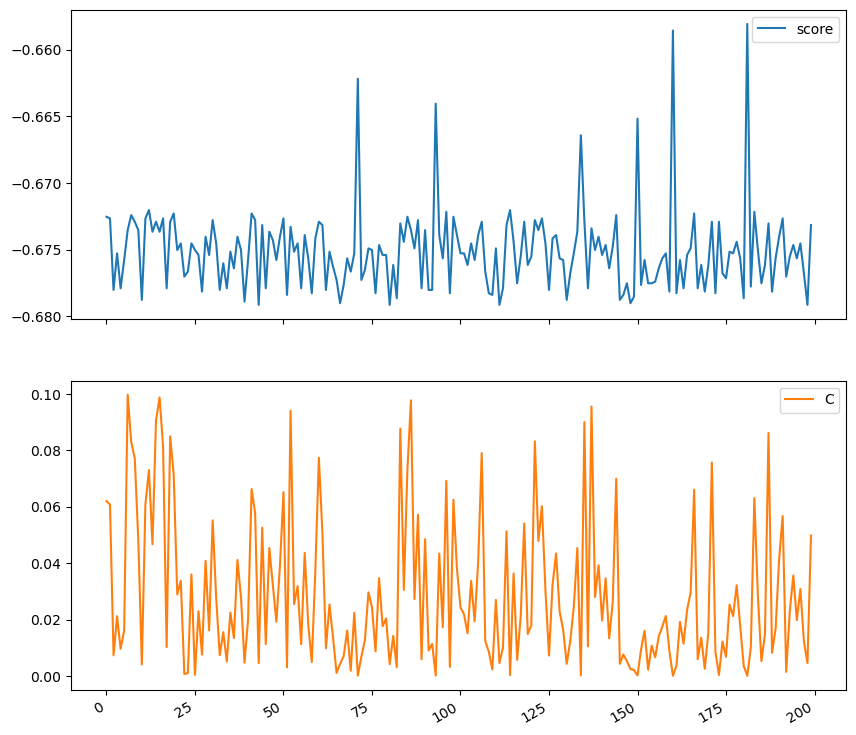

In [276]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

In [277]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, hyp_rfe, X_test_full, X_test_full_rfe, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6795063575168288     0.6709050112191474     -0.00860134629768139      Accuracy: Model 1 better
AUC:  0.7432815362882359     0.7382111137530245     -0.005070422535211394      AUC: Model 1 better


## The optimized logistic regression model with the full set of variables still performs the best

## Next we should examine if there are high correlations between certain variables by first visually inspecting a correlation plot

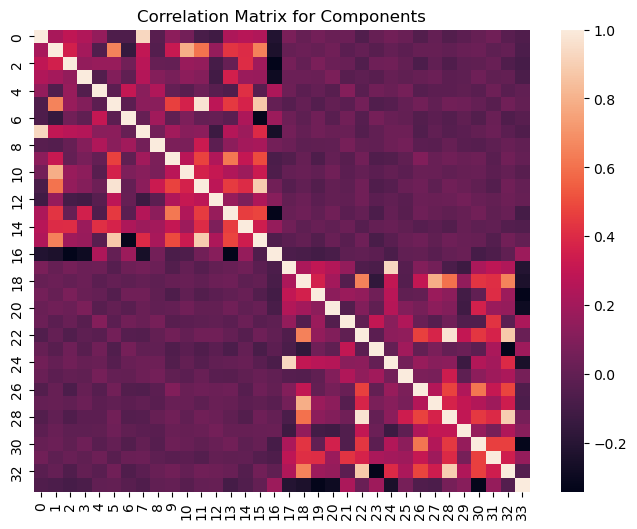

In [166]:
#examining the correlations between the standardized continuous variables
fig, ax = plt.subplots(figsize=(8,6))
corr_mat = np.corrcoef(X_train_std.transpose())
sns.heatmap(corr_mat)
ax.set(title = 'Correlation Matrix for Components')
plt.show()

## We see that the variables from team 1 have low to no correlation with team 2, however we also see that some of the variables within a team have high correlations. Lets explore that further.

In [194]:
#create a dataframe of correlations
corr_frame = pd.DataFrame()


for i in X_train_std.columns:
    for j in X_train_std.columns:
        value = X_train_std[i].corr(X_train_std[j])
        df2 = {'Var1': i, 'Correlation': value, 'Var2': j}
        corr_frame = corr_frame.append(df2, ignore_index = True)

corr_frame = corr_frame.reset_index(drop = True)
#filter correlations above 0.7
pd.options.display.max_rows = 70
corr_frame = corr_frame[(corr_frame['Correlation'] < 0.99) & (corr_frame['Correlation'] > 0.7)]
display(corr_frame)
pd.options.display.max_rows = 10

,Correlation,Var1,Var2
7,0.927978,ORB,ORB%
44,0.785801,AST,AST%
181,0.970025,eFG,TS%
185,0.874566,eFG,OffRt
238,0.927978,ORB%,ORB
341,0.785801,AST%,AST
379,0.970025,TS%,eFG
389,0.889900,TS%,OffRt
515,0.874566,OffRt,eFG
521,0.889900,OffRt,TS%


## Many of the high correlations have to do with a variable and its % version, lets look at the VIF values to help

In [195]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_std.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_std.values, i) for i in range(len(X_train_std.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

,Attribute,VIF Scores
0,ORB,37.970132
1,AST,19.298454
2,STL,2.552055
3,BLK,1.352131
4,PF,1.537351
5,eFG,70.820764
6,TOV%,26.659039
7,ORB%,25.351726
8,FT/FGA,5.374595
9,DRB%,2.360644


## Many variables have extremely high VIF scores, lets remove several and see how it improves our model. We can also remember that our variable importance chart previous indicated that many of our variables were not that important

In [278]:
#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#remove certain variables with high VIF factors
X_train_sub = X_train_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                            'FT', 'FT.1',
                            'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

X_test_sub = X_test_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                           'FT', 'FT.1',
                           'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

#combine continuous and categorical variables
X_train_sub_d = pd.concat([X_train_sub, dummy_train], axis = 1)
X_test_sub_d = pd.concat([X_test_sub, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full_sub = X_train_sub_d.drop(['Location_N'], axis = 1)
X_test_full_sub = X_test_sub_d.drop(['Location_N'], axis = 1)

## Reinspect the VIF values

In [279]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_full_sub.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_full_sub.values, i) for i in range(len(X_train_full_sub.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

,Attribute,VIF Scores
0,STL,1.720680
1,BLK,1.259203
2,PF,1.465937
3,TOV%,1.654625
4,ORB%,1.526980
5,FT/FGA,1.267851
6,DRB%,1.599301
7,AST%,1.314062
8,3PAr,1.298309
9,POSS,2.088369


## VIF scores look great, lets try modelling with this reduced set of variables

In [282]:
logreg_sub = LogisticRegression(max_iter = 5000, random_state = 42)

logreg_sub.fit(X_train_full_sub, y_train)

LogisticRegression(max_iter=5000, random_state=42)

Model Performance

Accuracy =  0.6787584143605087 

Classification Report

              precision    recall  f1-score   support

           0     0.6859    0.6701    0.6779      1349
           1     0.6718    0.6875    0.6796      1325

    accuracy                         0.6788      2674
   macro avg     0.6789    0.6788    0.6788      2674
weighted avg     0.6789    0.6788    0.6787      2674



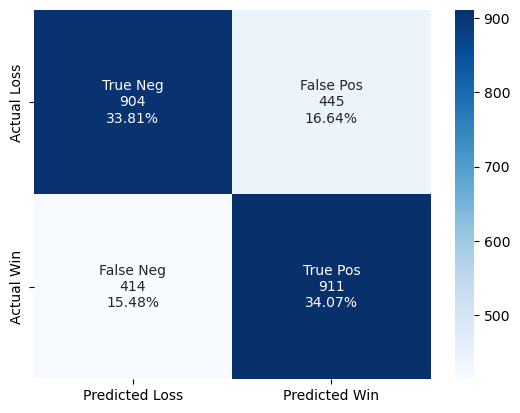

In [283]:
evaluate_classification(logreg_sub, X_test_full_sub, y_test)

In [284]:
#comparing the reduced variable model to the optimized full variable model
compare_classification(hyp_logreg, logreg_sub, X_test_full, X_test_full_sub, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6795063575168288     0.6787584143605087     -0.0007479431563200967      Accuracy: Model 1 better
AUC:  0.7432815362882359     0.7423371609997622     -0.0009443752884736867      AUC: Model 1 better


## The optimized full set still performs best, lets try optimizing the reduced varible model

In [305]:
def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    return cross_val_score(model, X_train_full_sub, y_train).mean()


In [306]:
space = {
    'penalty': hp.choice('penalty', ['l2']),
    'solver': hp.choice('solver', ['saga',
                                   'liblinear',
                                  'lbfgs',
                                  'sag']),
    'C': hp.uniform('C', 0.0,1.0),
    'max_iter': 5000,
    'random_state': 42,
}


In [324]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
        print('new best:', best, params, count)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=200, trials=trials,
            rstate = np.random.default_rng(42))
print('best:')
print(best)

new best:                                                                         
0.6771400413501493                                                                
{'C': 0.620118997676641, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
1                                                                                 
new best:                                                                         
0.6785117679911263                                                                
{'C': 0.07366102545052411, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
3                                                                                 
new best:                                                                         
0.6800081829114052                                                                
{'C': 0.007405377471122243, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
23                                   

In [325]:
#examine best parameters
best3 = space_eval(space, best)
best3

{'C': 0.006244859972228736,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga'}

In [326]:
#train model using best parameters
hyp_sub = LogisticRegression(C = best3['C'],
                  max_iter = best3['max_iter'],
                  penalty = best3['penalty'],
                  solver = best3['solver'],
                  random_state =  best3['random_state'])

hyp_sub.fit(X_train_full_sub, y_train)

LogisticRegression(C=0.006244859972228736, max_iter=5000, random_state=42,
                   solver='saga')

In [327]:
y_pred = hyp_sub.predict(X_train_full_sub)
print('Training Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_train, y_pred))


Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3980
           1       0.68      0.69      0.68      4039

    accuracy                           0.68      8019
   macro avg       0.68      0.68      0.68      8019
weighted avg       0.68      0.68      0.68      8019



In [328]:
y_pred = hyp_sub.predict(X_test_full_sub)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_test, y_pred))


Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.69      0.68      0.68      1349
           1       0.68      0.69      0.68      1325

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.681750186985789 

Classification Report

              precision    recall  f1-score   support

           0     0.6872    0.6775    0.6823      1349
           1     0.6763    0.6860    0.6812      1325

    accuracy                         0.6818      2674
   macro avg     0.6818    0.6818    0.6817      2674
weighted avg     0.6818    0.6818    0.6818      2674



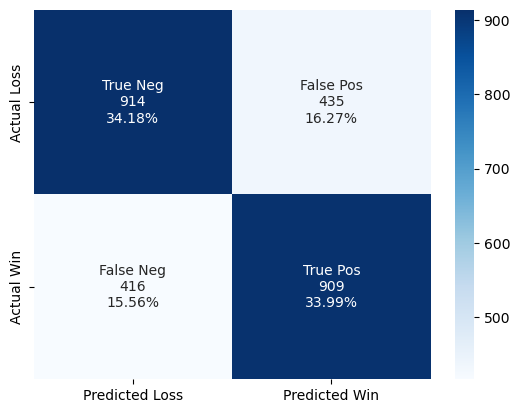

In [329]:
evaluate_classification(hyp_sub, X_test_full_sub, y_test)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

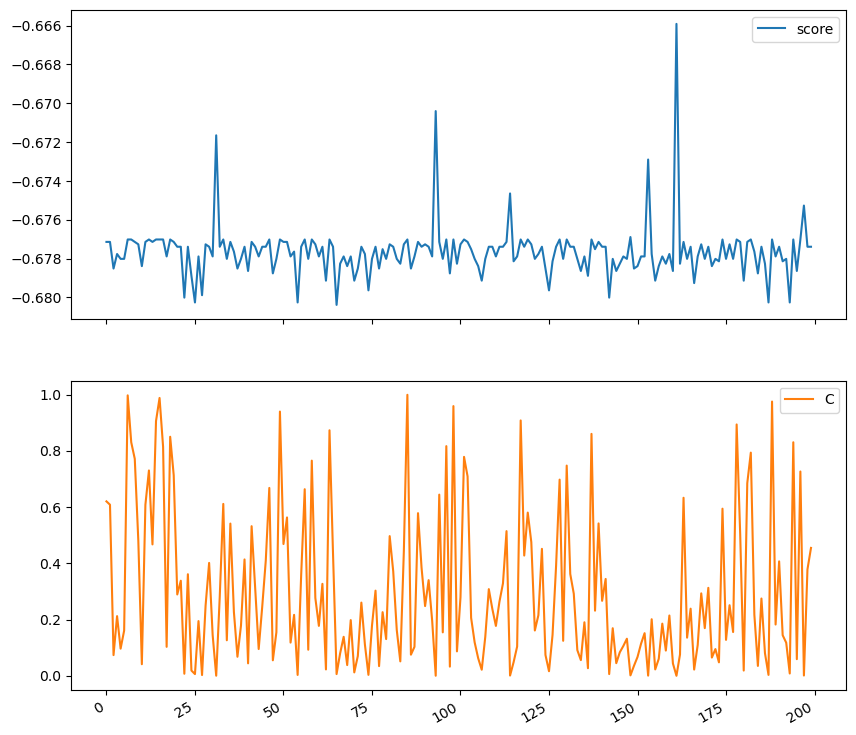

In [314]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss'],
                      x['misc']['vals']['C'][0]] for x in trials.trials])
results_df=pd.DataFrame(results,
                           columns=['score', 'C'])
results_df.plot(subplots=True,figsize=(10, 10))

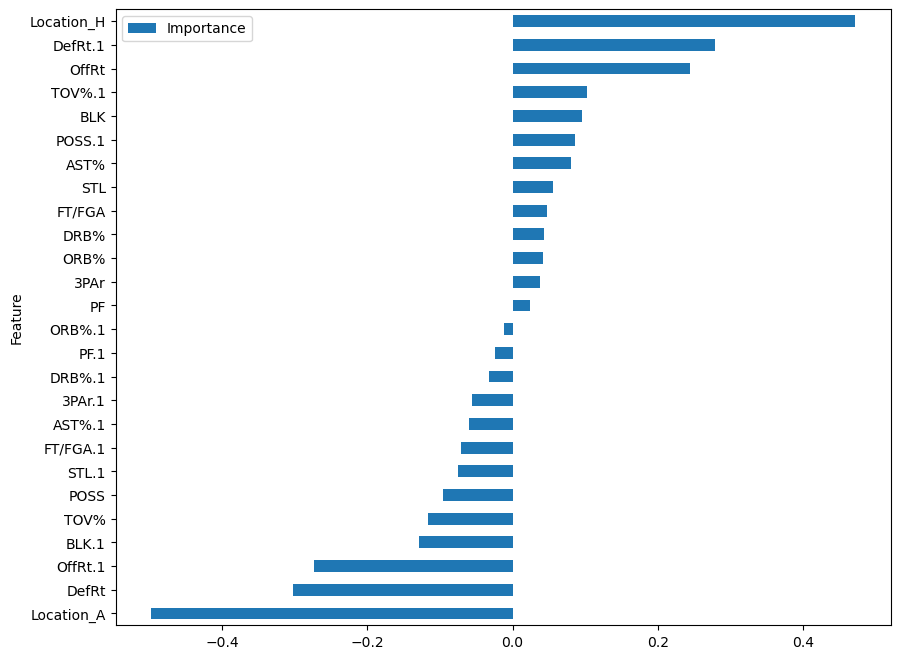

In [316]:
#examining variable importance
coefficients = hyp_sub.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full_sub.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()


In [317]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
24  Location_A   -0.497993
11       DefRt   -0.302200
22     OffRt.1   -0.273181
13       BLK.1   -0.128261
3         TOV%   -0.115833
9         POSS   -0.095188
12       STL.1   -0.074744
17    FT/FGA.1   -0.070955
19      AST%.1   -0.060344
20      3PAr.1   -0.055468
18      DRB%.1   -0.032600
14        PF.1   -0.023531
16      ORB%.1   -0.011127
2           PF    0.023392
8         3PAr    0.038144
4         ORB%    0.041279
6         DRB%    0.043638
5       FT/FGA    0.046728
0          STL    0.055444
7         AST%    0.080370
21      POSS.1    0.086215
1          BLK    0.094962
15      TOV%.1    0.102822
10       OffRt    0.244854
23     DefRt.1    0.278461
25  Location_H    0.471691


In [313]:
#comparing the optimized reduced variable model to the optimized full variable model
compare_classification(hyp_logreg, hyp_sub, X_test_full, X_test_full_sub, y_test)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.6795063575168288     0.681750186985789     0.00224382946896029      Accuracy: Model 2 better
AUC:  0.7432815362882359     0.743038728897716     -0.00024280739051985023      AUC: Model 1 better


## Both the optimized full variable model and reduced variable models perform quite well, with the reduced variables having better accuracy and full variables having slightly better AUC score. Either model would perform well, but the margin of accuracy is larger than the margin of AUC, so the reduced variable model will be the one we go with.

# Conclusion

## After exploring the variable relationships and variable importance graphs, it appears there playing location and offensive and defense rating are the most valuable features. This makes sense when you consider 'home court advantage' as well as the fact that offensive and defense rating take into account a multitude of both offensive and defense statistics. The reduced variable optimized model performed best with the full variable optimized model coming in a very close second

## Next notebook will explore using a Gradient boosting model

In [ ]:
#saving best model results here
best_hype = {'C': 0.006244859972228736,
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga'}

#train model using best parameters from search
hyp_sub = LogisticRegression(C = best_hype['C'],
                  max_iter = best_hype['max_iter'],
                  penalty = best_hype['penalty'],
                  solver = best_hype['solver'],
                  random_state =  best_hype['random_state'])

hyp_sub.fit(X_train_full_sub, y_train)

